In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math

from NN_utils import BigTable, WeightClip

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps-1))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")

Using TensorFlow backend.


started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions



# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [3]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform((-5), (5), size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors))
    
    minb=-(test_w/2) - d50 - a0
    maxb=(test_w/2) - d50 - a0
    questions = questions - minb - 5
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)                
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
            
    return students, questions

def gen_rasch_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
#             zmask = (questions[mi] < 0.001).astype(int)
            diffs = students[vi]-questions[mi]
            prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions



In [4]:
# from scipy.stats import beta
# # n_questions = 100
# # n_students = 100
# # n_factors = 2

# def gen_run(n_movies, n_viewers, n_factors, min_active, max_active):
#     from numpy.random import randint, uniform

#     mina,maxa =(0,1)
#     minb,maxb =(0,1)
#     movies = randint(minb, maxb+1, size=(n_movies, n_factors))
#     viewers = randint(mina, maxa+1, size=(n_viewers, n_factors))
# #     movies =  beta.rvs(2, 2, size=(n_movies, n_factors))
# #     viewers = beta.rvs(2, 2, size=(n_movies, n_factors))

#     plt.hist(movies.flatten(), alpha=0.5)
#     plt.hist(viewers.flatten(), alpha=0.5)
#     plt.show()
    
#     print(movies)
#     print(viewers)

#     sig = lambda z : 1/(1+numpy.exp(-z))

#     obs = numpy.zeros((len(viewers), len(movies)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(viewers)):
#         for mi in range(len(movies)):
# #             obs[vi,mi] = numpy.prod(sig(viewers[vi] - movies[mi]))
#             obs[vi,mi] = numpy.dot(viewers[vi], movies[mi])
# #             prxd = numpy.multiply(viewers[vi], movies[mi])
# #             obs[vi,mi] = numpy.sum(prxd)
# #             obs[vi,mi] = numpy.random.randint(0,2)
#             print(viewers[vi], movies[mi],"=",obs[vi,mi])
#     plt.hist(obs.flatten())
#     plt.show()
    
#     return obs, None, viewers, movies

genqs (100, 2) (100, 2)
(100, 2) (100, 2)


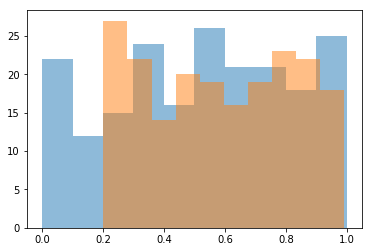

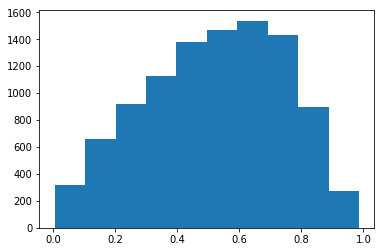

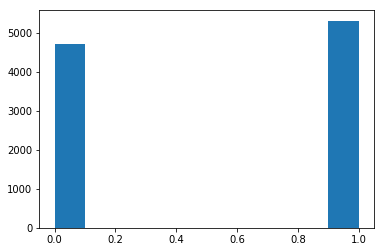

In [5]:
n_students, n_questions, n_factors, min_active, max_active = 100,100,2,2,2

numpy.set_printoptions(precision=3)
test_w = 5
#rasch a0 = 3
# a0 = 0.26 #bayes10
a0 = (0.2,1)
a1 = None
obs, probs, students, questions  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)

plt.hist(students.flatten(), alpha=0.5)
plt.hist(questions.flatten(), alpha=0.5)
plt.show()

plt.hist(probs.flatten())
plt.show()

plt.hist(obs.flatten())
plt.show()

In [6]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda
from keras import backend as K, Model
def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
#     qn_row = GaussianNoise(.5)(qn_row)
    psi_row = psi_table(psi_sel)
#     psi_row = GaussianNoise(0.5)(psi_row)
    
#     prds = multiply([qn_row, psi_row])
#     difs = subtract([psi_row, qn_row])
#     score = Lambda(lambda ps: K.sum(ps, keepdims=True)/n_factors, name="score")(prds)
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
    
    Prs = Lambda(lambda qs: (1 - qs[0])+qs[0]*qs[1], name="Prs")([qn_row, psi_row])
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])

    print(model.summary())

    return model

In [7]:
# from NN_utils import BigTable, WeightClip
# from keras.optimizers import Adam

# inv_sigmoid = lambda p: -numpy.log(1/p - 1)
# p50 = inv_sigmoid( 0.5**(1/n_factors) )

# s_table =  BigTable((n_viewers, n_factors), 0, 1, init_hilo=None)#, regulariser=regularizers.l2(10e-8))
# qn_table = BigTable((n_movies, n_factors), 0, 1, init_hilo=None)#, regulariser=regularizers.l2(10e-8))

# m = generate_qs_model(qn_table, s_table, Adam())

In [8]:
# vz = []
# mz = []
# scz =[]
# pz =[]

# # frak = 12000/(n_movies*n_viewers)
# # print(frak)

# from collections import defaultdict

# frak = 1
# all_pairs = [(v,m) for v in range(n_viewers) for m in range(n_movies)]
# pairs_to_use = all_pairs
# if frak != 1:
#     all_pair_ixs = list(range(len(all_pairs)))
#     print(all_pairs[0:10])
#     pairs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10000)), replace=True)
#     pairs_to_use = numpy.array(all_pairs)[pairs_to_use]

# all_scz = []
# for vi,mi in pairs_to_use:
#         sc = numpy.sum(numpy.multiply(viewers[vi],movies[mi]))
#         vz.append(vi)
#         mz.append(mi)
#         all_scz.append(sc)

# del all_pairs
# del pairs_to_use
    
# all_ixs = range(len(all_scz))
# val_ixs = numpy.random.choice(all_ixs, size=2*int(min(len(all_scz)/10,1000)), replace=False) #len(attempts)//100, replace=False)
# trn_ixs = list(set(all_ixs) - set(val_ixs))
# test_ixs = val_ixs[0:len(val_ixs)//2]
# val_ixs = val_ixs[len(val_ixs)//2:]
        
# all_vz = numpy.array(vz).reshape([-1,1])
# all_mz = numpy.array(mz).reshape([-1,1])
# all_scz = numpy.array(all_scz).reshape([-1,1])

# vvz = all_vz[val_ixs]
# vmz = all_mz[val_ixs]
# vscz = all_scz[val_ixs]

# tvz = all_vz[test_ixs]
# tmz = all_mz[test_ixs]
# tscz = all_scz[test_ixs]

# vz = all_vz[trn_ixs]
# mz = all_mz[trn_ixs]
# scz = all_scz[trn_ixs]

In [9]:
for vi,mi,sc in zip(vz,mz,all_scz):
    print(vi,mi,sc)

NameError: name 'vz' is not defined

In [30]:
def generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=n_factors):
#     s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo=0.5)#, regulariser=regularizers.l2(10e-6))
#     qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0.5)#, regulariser=regularizers.l1(10e-6))
    s_table =  BigTable((n_students, w), 0, 1, init_hilo=None)#, regulariser=regularizers.l2(10e-6))
    qn_table = BigTable((n_questions, w), 0, 1, init_hilo=None)#, regulariser=regularizers.l1(10e-6))

    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
    q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping
    m = generate_qs_model(qn_table, s_table, Adam())#, s_train=True, q_train=True)
    if vqz:
        lozz="val_loss"
        v_data=[[vqz,vsz], vpfz]
    else:
        lozz="loss"
        v_data = None
    es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=100)
    h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=100000, verbose=1, callbacks=[es], validation_data=v_data)

#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
initpfz = [50 for _ in range(len(pfz))]
m.fit(x=[mz,vz], y=pfz, batch_size=1000, shuffle=True, epochs=1000, verbose=1)#, callbacks=[es], validation_split=1000/len(initpfz))

genqs (1000, 2) (100, 2)
(1000, 2) (100, 2)
2 comps, so no dim reduc
pred list shape (0,)
real items shape (100, 2)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


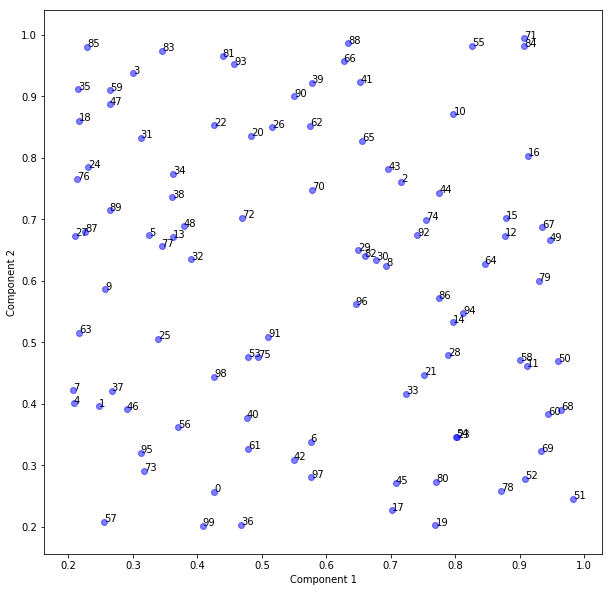

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 0 (0.2, 1)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


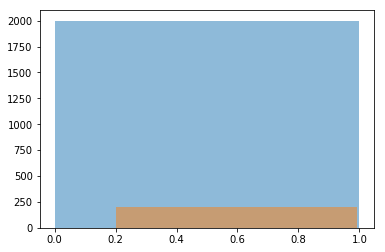

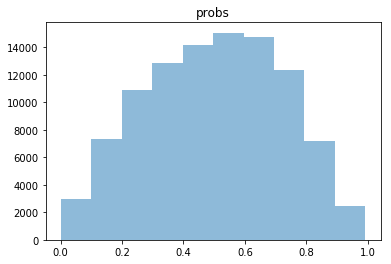

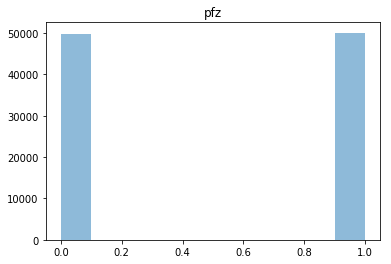

binary obs? True
<NN_utils.BigTable object at 0x7f45d8dca7f0> <NN_utils.BigTable object at 0x7f45d8dcacf8> Tensor("psi_select_55:0", shape=(?, 1), dtype=int32) Tensor("q_select_55:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f45d8dd96a0>
kk (100, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 2)
'rows' shape, (?, 2)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f45d8ddf470>
kk (1000, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 2)
'rows' shape, (?, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q_select (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
psi_select (InputLayer)     

Epoch 57/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7790 - acc: 0.5340
Epoch 58/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7779 - acc: 0.5344
Epoch 59/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7768 - acc: 0.5348
Epoch 60/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7757 - acc: 0.5353
Epoch 61/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7746 - acc: 0.5357
Epoch 62/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7735 - acc: 0.5360
Epoch 63/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7724 - acc: 0.5368
Epoch 64/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7714 - acc: 0.5371
Epoch 65/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7703 - acc: 0.5375
Epoch 66/100000
100000/100000 [===============

Epoch 134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7157 - acc: 0.5669
Epoch 135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7151 - acc: 0.5672
Epoch 136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7145 - acc: 0.5675
Epoch 137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7139 - acc: 0.5681
Epoch 138/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7133 - acc: 0.5684
Epoch 139/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7127 - acc: 0.5688
Epoch 140/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7121 - acc: 0.5692
Epoch 141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7115 - acc: 0.5696
Epoch 142/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7110 - acc: 0.5699
Epoch 143/100000
100000/100000 [=====

Epoch 211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6785 - acc: 0.5935
Epoch 212/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.6782 - acc: 0.5938
Epoch 213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6778 - acc: 0.5943
Epoch 214/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6774 - acc: 0.5946
Epoch 215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6770 - acc: 0.5950
Epoch 216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6767 - acc: 0.5952
Epoch 217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6763 - acc: 0.5955
Epoch 218/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6759 - acc: 0.5958
Epoch 219/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6755 - acc: 0.5961
Epoch 220/100000
100000/100000 [=====

Epoch 288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6543 - acc: 0.6150
Epoch 289/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6541 - acc: 0.6153
Epoch 290/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6538 - acc: 0.6155
Epoch 291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6536 - acc: 0.6157
Epoch 292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6533 - acc: 0.6159
Epoch 293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6530 - acc: 0.6160
Epoch 294/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6528 - acc: 0.6161
Epoch 295/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6525 - acc: 0.6164
Epoch 296/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6523 - acc: 0.6167
Epoch 297/100000
100000/100000 [=====

Epoch 365/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6376 - acc: 0.6315
Epoch 366/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6375 - acc: 0.6317
Epoch 367/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6373 - acc: 0.6319
Epoch 368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6371 - acc: 0.6321
Epoch 369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6369 - acc: 0.6323
Epoch 370/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6367 - acc: 0.6325
Epoch 371/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6366 - acc: 0.6328
Epoch 372/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6364 - acc: 0.6329
Epoch 373/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6362 - acc: 0.6330
Epoch 374/100000
100000/100000 [=====

Epoch 442/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6258 - acc: 0.6442
Epoch 443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6256 - acc: 0.6444
Epoch 444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6255 - acc: 0.6446
Epoch 445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6254 - acc: 0.6447
Epoch 446/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6252 - acc: 0.6448
Epoch 447/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6251 - acc: 0.6450
Epoch 448/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6250 - acc: 0.6451
Epoch 449/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6249 - acc: 0.6453
Epoch 450/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6247 - acc: 0.6455
Epoch 451/100000
100000/100000 [=====

Epoch 519/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6171 - acc: 0.6541
Epoch 520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6170 - acc: 0.6542
Epoch 521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6169 - acc: 0.6543
Epoch 522/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.6168 - acc: 0.6544
Epoch 523/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.6167 - acc: 0.6545
Epoch 524/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6166 - acc: 0.6546
Epoch 525/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.6165 - acc: 0.6548
Epoch 526/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.6165 - acc: 0.6549
Epoch 527/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.6164 - acc: 0.6549
Epoch 528/100000
100000/100000 [=====

Epoch 596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6107 - acc: 0.6608
Epoch 597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6107 - acc: 0.6608
Epoch 598/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6106 - acc: 0.6610
Epoch 599/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6105 - acc: 0.6610
Epoch 600/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6105 - acc: 0.6610
Epoch 601/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6104 - acc: 0.6610
Epoch 602/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6103 - acc: 0.6611
Epoch 603/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6102 - acc: 0.6612
Epoch 604/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6102 - acc: 0.6613
Epoch 605/100000
100000/100000 [=====

Epoch 673/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6060 - acc: 0.6651
Epoch 674/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6059 - acc: 0.6651
Epoch 675/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6058 - acc: 0.6652
Epoch 676/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6058 - acc: 0.6653
Epoch 677/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6057 - acc: 0.6654
Epoch 678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6057 - acc: 0.6654
Epoch 679/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6056 - acc: 0.6655
Epoch 680/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6056 - acc: 0.6655
Epoch 681/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6055 - acc: 0.6655
Epoch 682/100000
100000/100000 [=====

Epoch 750/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6023 - acc: 0.6686
Epoch 751/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6023 - acc: 0.6686
Epoch 752/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6023 - acc: 0.6687
Epoch 753/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6022 - acc: 0.6686
Epoch 754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6022 - acc: 0.6687
Epoch 755/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6021 - acc: 0.6687
Epoch 756/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6021 - acc: 0.6687
Epoch 757/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6021 - acc: 0.6688
Epoch 758/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6020 - acc: 0.6689
Epoch 759/100000
100000/100000 [=====

Epoch 827/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5996 - acc: 0.6711
Epoch 828/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5995 - acc: 0.6711
Epoch 829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5995 - acc: 0.6711
Epoch 830/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5995 - acc: 0.6712
Epoch 831/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5994 - acc: 0.6712
Epoch 832/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5994 - acc: 0.6712
Epoch 833/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5994 - acc: 0.6712
Epoch 834/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5993 - acc: 0.6712
Epoch 835/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5993 - acc: 0.6712
Epoch 836/100000
100000/100000 [=====

Epoch 904/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5974 - acc: 0.6731
Epoch 905/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5974 - acc: 0.6731
Epoch 906/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5973 - acc: 0.6731
Epoch 907/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5973 - acc: 0.6732
Epoch 908/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5973 - acc: 0.6733
Epoch 909/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5973 - acc: 0.6733
Epoch 910/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5972 - acc: 0.6734
Epoch 911/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5972 - acc: 0.6733
Epoch 912/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5972 - acc: 0.6734
Epoch 913/100000
100000/100000 [=====

Epoch 981/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5957 - acc: 0.6747
Epoch 982/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5957 - acc: 0.6747
Epoch 983/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5956 - acc: 0.6747
Epoch 984/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5956 - acc: 0.6747
Epoch 985/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5956 - acc: 0.6747
Epoch 986/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5956 - acc: 0.6747
Epoch 987/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5956 - acc: 0.6747
Epoch 988/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5955 - acc: 0.6748
Epoch 989/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5955 - acc: 0.6749
Epoch 990/100000
100000/100000 [=====

100000/100000 [==============================] - 0s 1us/step - loss: 0.5943 - acc: 0.6761
Epoch 1058/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5943 - acc: 0.6761
Epoch 1059/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5943 - acc: 0.6762
Epoch 1060/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5943 - acc: 0.6762
Epoch 1061/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5943 - acc: 0.6762
Epoch 1062/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5942 - acc: 0.6762
Epoch 1063/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5942 - acc: 0.6762
Epoch 1064/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5942 - acc: 0.6762
Epoch 1065/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5942 - acc: 0.6762
Epoch 1066/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5932 - acc: 0.6771
Epoch 1134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5932 - acc: 0.6771
Epoch 1135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5932 - acc: 0.6771
Epoch 1136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5931 - acc: 0.6770
Epoch 1137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5931 - acc: 0.6770
Epoch 1138/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5931 - acc: 0.6770
Epoch 1139/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5931 - acc: 0.6770
Epoch 1140/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5931 - acc: 0.6770
Epoch 1141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5931 - acc: 0.6770
Epoch 1142/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5922 - acc: 0.6778
Epoch 1210/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5922 - acc: 0.6779
Epoch 1211/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5922 - acc: 0.6779
Epoch 1212/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5922 - acc: 0.6780
Epoch 1213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5922 - acc: 0.6780
Epoch 1214/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5922 - acc: 0.6780
Epoch 1215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5922 - acc: 0.6779
Epoch 1216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5921 - acc: 0.6780
Epoch 1217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5921 - acc: 0.6780
Epoch 1218/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5914 - acc: 0.6789
Epoch 1286/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5914 - acc: 0.6789
Epoch 1287/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6789
Epoch 1288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6789
Epoch 1289/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6789
Epoch 1290/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6788
Epoch 1291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6788
Epoch 1292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6789
Epoch 1293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5913 - acc: 0.6789
Epoch 1294/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6796
Epoch 1362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6796
Epoch 1363/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6796
Epoch 1364/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6796
Epoch 1365/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6796
Epoch 1366/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6796
Epoch 1367/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5905 - acc: 0.6797
Epoch 1368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6797
Epoch 1369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6797
Epoch 1370/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6809
Epoch 1438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6809
Epoch 1439/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5897 - acc: 0.6809
Epoch 1440/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6810
Epoch 1441/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6810
Epoch 1442/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6810
Epoch 1443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6811
Epoch 1444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6811
Epoch 1445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5896 - acc: 0.6811
Epoch 1446/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6819
Epoch 1514/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6819
Epoch 1515/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6819
Epoch 1516/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6819
Epoch 1517/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6819
Epoch 1518/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6819
Epoch 1519/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6820
Epoch 1520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6820
Epoch 1521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6820
Epoch 1522/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6827
Epoch 1590/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6827
Epoch 1591/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6827
Epoch 1592/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6827
Epoch 1593/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6827
Epoch 1594/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6827
Epoch 1595/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6827
Epoch 1596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6827
Epoch 1597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6827
Epoch 1598/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6841
Epoch 1666/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6842
Epoch 1667/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6842
Epoch 1668/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6843
Epoch 1669/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6844
Epoch 1670/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6844
Epoch 1671/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6845
Epoch 1672/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6845
Epoch 1673/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5862 - acc: 0.6845
Epoch 1674/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6854
Epoch 1742/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6854
Epoch 1743/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6854
Epoch 1744/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6855
Epoch 1745/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6855
Epoch 1746/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6854
Epoch 1747/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6853
Epoch 1748/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6853
Epoch 1749/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6854
Epoch 1750/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6864
Epoch 1818/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6865
Epoch 1819/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6865
Epoch 1820/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6865
Epoch 1821/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6865
Epoch 1822/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6865
Epoch 1823/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6865
Epoch 1824/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6866
Epoch 1825/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5833 - acc: 0.6866
Epoch 1826/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6876
Epoch 1894/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6876
Epoch 1895/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6877
Epoch 1896/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6876
Epoch 1897/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6876
Epoch 1898/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6877
Epoch 1899/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6877
Epoch 1900/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6877
Epoch 1901/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6877
Epoch 1902/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6887
Epoch 1970/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6887
Epoch 1971/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6886
Epoch 1972/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6886
Epoch 1973/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6887
Epoch 1974/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6887
Epoch 1975/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6887
Epoch 1976/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5808 - acc: 0.6887
Epoch 1977/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5808 - acc: 0.6887
Epoch 1978/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6898
Epoch 2046/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6898
Epoch 2047/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6898
Epoch 2048/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6898
Epoch 2049/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5800 - acc: 0.6898
Epoch 2050/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5799 - acc: 0.6899
Epoch 2051/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5799 - acc: 0.6899
Epoch 2052/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5799 - acc: 0.6898
Epoch 2053/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5799 - acc: 0.6898
Epoch 2054/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5793 - acc: 0.6900
Epoch 2122/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5793 - acc: 0.6900
Epoch 2123/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5793 - acc: 0.6900
Epoch 2124/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5793 - acc: 0.6899
Epoch 2125/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5792 - acc: 0.6899
Epoch 2126/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5792 - acc: 0.6900
Epoch 2127/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5792 - acc: 0.6900
Epoch 2128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5792 - acc: 0.6899
Epoch 2129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5792 - acc: 0.6900
Epoch 2130/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6903
Epoch 2198/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6903
Epoch 2199/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6904
Epoch 2200/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6904
Epoch 2201/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6904
Epoch 2202/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6904
Epoch 2203/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6904
Epoch 2204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6905
Epoch 2205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5787 - acc: 0.6904
Epoch 2206/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2274/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2275/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2276/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2277/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5783 - acc: 0.6905
Epoch 2278/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6905
Epoch 2281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5783 - acc: 0.6904
Epoch 2282/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2350/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2351/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2352/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6908
Epoch 2353/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2354/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5780 - acc: 0.6907
Epoch 2358/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2426/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2427/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2428/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2429/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2430/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6909
Epoch 2431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6909
Epoch 2433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5777 - acc: 0.6908
Epoch 2434/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2502/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2503/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2504/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2505/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2506/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6909
Epoch 2510/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6912
Epoch 2578/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6912
Epoch 2579/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6912
Epoch 2580/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 2581/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 2582/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 2583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 2584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 2585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 2586/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 2654/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 2655/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 2656/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 2657/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 2658/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 2659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 2660/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 2661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 2662/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6912
Epoch 2730/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6912
Epoch 2731/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6912
Epoch 2732/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6912
Epoch 2733/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6912
Epoch 2734/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6912
Epoch 2735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6913
Epoch 2736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6913
Epoch 2737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5772 - acc: 0.6913
Epoch 2738/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 0us/step - loss: 0.5771 - acc: 0.6914
Epoch 2806/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6914
Epoch 2807/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6914
Epoch 2808/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6914
Epoch 2809/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6914
Epoch 2810/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6915
Epoch 2811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6915
Epoch 2812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6915
Epoch 2813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5771 - acc: 0.6915
Epoch 2814/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2882/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2883/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2884/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2885/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2886/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2890/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2958/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2959/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2960/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2961/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2962/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6917
Epoch 2966/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3034/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3035/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3036/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3037/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3038/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3040/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5769 - acc: 0.6916
Epoch 3041/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3042/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3110/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3111/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3112/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3113/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6916
Epoch 3114/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5769 - acc: 0.6917
Epoch 3118/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3186/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3187/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3188/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3189/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3190/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3194/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3262/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3263/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3264/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3265/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3266/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3269/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3270/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3338/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3339/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3340/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3341/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3342/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3345/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3346/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3414/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3415/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3416/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3417/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3418/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3420/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3421/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6917
Epoch 3422/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3490/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3491/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3492/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3493/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3494/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6919
Epoch 3495/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3496/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3497/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3498/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3566/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3567/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3568/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3569/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3570/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3571/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3572/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3573/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3574/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3642/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3643/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3644/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3645/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3646/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5768 - acc: 0.6918
Epoch 3647/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3648/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3649/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3650/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3718/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3719/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3720/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3721/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3722/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 3723/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3724/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3725/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3726/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3794/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3795/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3796/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3797/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3798/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3799/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3800/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3801/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3802/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3870/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3871/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3872/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3873/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3874/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3875/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3876/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3877/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6920
Epoch 3878/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3946/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3947/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5767 - acc: 0.6919
Epoch 3948/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3949/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3950/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3951/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3952/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3953/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 3954/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4022/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4023/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4024/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4025/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4026/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4027/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4028/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4029/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4030/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4098/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4099/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4100/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4101/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4102/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4103/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4104/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4105/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4106/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4174/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4175/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4176/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4177/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4178/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4179/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4180/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4181/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4182/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4250/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4251/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4252/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4253/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4254/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4255/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4256/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4257/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4258/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4326/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4327/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4328/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4329/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4330/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4331/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4332/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4333/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4334/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4402/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4403/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4404/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4405/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4406/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4407/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4408/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4409/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4410/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4478/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4479/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4480/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4481/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4482/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4483/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4484/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4485/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4486/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4554/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4555/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4556/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4557/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4558/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4559/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4560/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4561/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4562/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4630/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4631/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4632/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4633/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4634/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4635/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4636/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4637/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4638/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4706/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4707/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4708/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4709/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4710/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4711/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4712/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4713/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6919
Epoch 4714/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4782/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4783/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4784/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4785/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4786/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4787/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4788/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4789/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4790/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4858/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4859/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4860/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4861/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4862/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4863/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4864/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4865/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5767 - acc: 0.6918
Epoch 4866/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4934/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4935/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4936/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4937/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4938/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4939/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4940/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4941/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 4942/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5010/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5011/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5012/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5013/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5014/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5015/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5016/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5017/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5018/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5086/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5087/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5088/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5089/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5090/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5091/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5092/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6918
Epoch 5094/100000
100000/100000 [=============

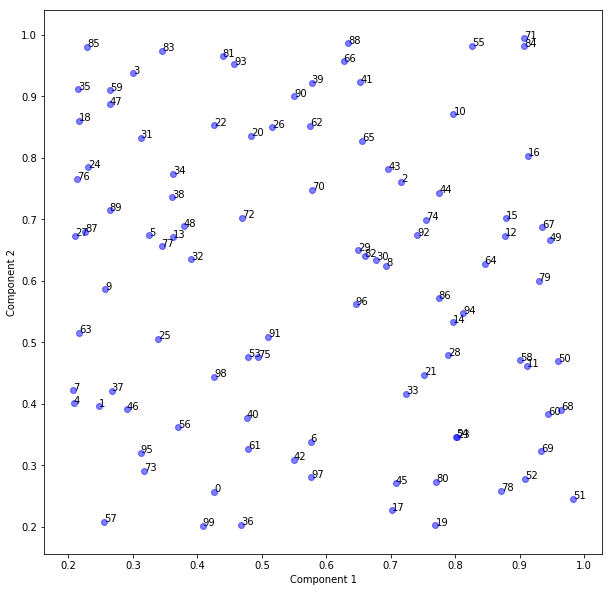

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 1 (0.2, 1)


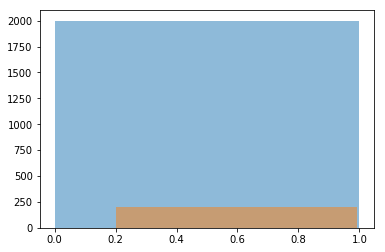

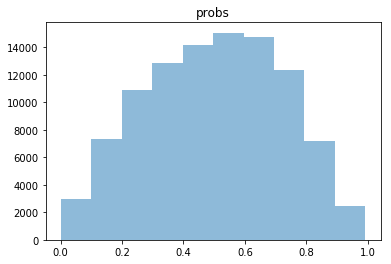

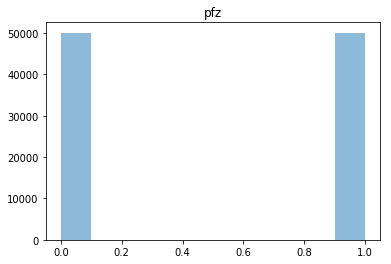

binary obs? True
<NN_utils.BigTable object at 0x7f45d88f9ac8> <NN_utils.BigTable object at 0x7f45d8899940> Tensor("psi_select_56:0", shape=(?, 1), dtype=int32) Tensor("q_select_56:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f45d87e5eb8>
kk (100, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 2)
'rows' shape, (?, 2)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f45d8789080>
kk (1000, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 2)
'rows' shape, (?, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q_select (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
psi_select (InputLayer)     

Epoch 57/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7861 - acc: 0.5335
Epoch 58/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7849 - acc: 0.5339
Epoch 59/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7837 - acc: 0.5342
Epoch 60/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7826 - acc: 0.5345
Epoch 61/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7815 - acc: 0.5349
Epoch 62/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7804 - acc: 0.5352
Epoch 63/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7793 - acc: 0.5357
Epoch 64/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7782 - acc: 0.5361
Epoch 65/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7771 - acc: 0.5363
Epoch 66/100000
100000/100000 [===============

Epoch 134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7201 - acc: 0.5624
Epoch 135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7194 - acc: 0.5628
Epoch 136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7188 - acc: 0.5633
Epoch 137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7182 - acc: 0.5637
Epoch 138/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7176 - acc: 0.5642
Epoch 139/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7170 - acc: 0.5645
Epoch 140/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7163 - acc: 0.5648
Epoch 141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7157 - acc: 0.5651
Epoch 142/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7151 - acc: 0.5656
Epoch 143/100000
100000/100000 [=====

Epoch 211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6813 - acc: 0.5888
Epoch 212/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6809 - acc: 0.5891
Epoch 213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6805 - acc: 0.5894
Epoch 214/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6801 - acc: 0.5897
Epoch 215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6797 - acc: 0.5901
Epoch 216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6793 - acc: 0.5904
Epoch 217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6789 - acc: 0.5908
Epoch 218/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6785 - acc: 0.5910
Epoch 219/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6781 - acc: 0.5914
Epoch 220/100000
100000/100000 [=====

Epoch 288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6560 - acc: 0.6099
Epoch 289/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6558 - acc: 0.6100
Epoch 290/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6555 - acc: 0.6103
Epoch 291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6552 - acc: 0.6106
Epoch 292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6550 - acc: 0.6110
Epoch 293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6547 - acc: 0.6113
Epoch 294/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6544 - acc: 0.6115
Epoch 295/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6542 - acc: 0.6119
Epoch 296/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6539 - acc: 0.6122
Epoch 297/100000
100000/100000 [=====

Epoch 365/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6387 - acc: 0.6293
Epoch 366/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6385 - acc: 0.6295
Epoch 367/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6383 - acc: 0.6296
Epoch 368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6381 - acc: 0.6298
Epoch 369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6380 - acc: 0.6300
Epoch 370/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6378 - acc: 0.6302
Epoch 371/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6376 - acc: 0.6303
Epoch 372/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6374 - acc: 0.6304
Epoch 373/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6372 - acc: 0.6306
Epoch 374/100000
100000/100000 [=====

Epoch 442/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6263 - acc: 0.6421
Epoch 443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6262 - acc: 0.6423
Epoch 444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6261 - acc: 0.6425
Epoch 445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6259 - acc: 0.6427
Epoch 446/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6258 - acc: 0.6428
Epoch 447/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6257 - acc: 0.6430
Epoch 448/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6255 - acc: 0.6433
Epoch 449/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6254 - acc: 0.6435
Epoch 450/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6253 - acc: 0.6436
Epoch 451/100000
100000/100000 [=====

Epoch 519/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6173 - acc: 0.6531
Epoch 520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6172 - acc: 0.6531
Epoch 521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6171 - acc: 0.6533
Epoch 522/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6170 - acc: 0.6534
Epoch 523/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6169 - acc: 0.6535
Epoch 524/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6168 - acc: 0.6536
Epoch 525/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6167 - acc: 0.6537
Epoch 526/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6166 - acc: 0.6539
Epoch 527/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6165 - acc: 0.6541
Epoch 528/100000
100000/100000 [=====

Epoch 596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6105 - acc: 0.6606
Epoch 597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6104 - acc: 0.6607
Epoch 598/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6104 - acc: 0.6607
Epoch 599/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6103 - acc: 0.6607
Epoch 600/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6102 - acc: 0.6608
Epoch 601/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6101 - acc: 0.6609
Epoch 602/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6100 - acc: 0.6611
Epoch 603/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6100 - acc: 0.6612
Epoch 604/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6099 - acc: 0.6613
Epoch 605/100000
100000/100000 [=====

Epoch 673/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6053 - acc: 0.6670
Epoch 674/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6052 - acc: 0.6670
Epoch 675/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6052 - acc: 0.6671
Epoch 676/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6051 - acc: 0.6671
Epoch 677/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6050 - acc: 0.6672
Epoch 678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6050 - acc: 0.6674
Epoch 679/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6049 - acc: 0.6674
Epoch 680/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6049 - acc: 0.6673
Epoch 681/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6048 - acc: 0.6675
Epoch 682/100000
100000/100000 [=====

Epoch 750/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6012 - acc: 0.6712
Epoch 751/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6011 - acc: 0.6712
Epoch 752/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6011 - acc: 0.6713
Epoch 753/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6011 - acc: 0.6714
Epoch 754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6010 - acc: 0.6713
Epoch 755/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6010 - acc: 0.6714
Epoch 756/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6009 - acc: 0.6715
Epoch 757/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6009 - acc: 0.6714
Epoch 758/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6008 - acc: 0.6715
Epoch 759/100000
100000/100000 [=====

Epoch 827/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5979 - acc: 0.6740
Epoch 828/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5979 - acc: 0.6740
Epoch 829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5978 - acc: 0.6740
Epoch 830/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5978 - acc: 0.6740
Epoch 831/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5978 - acc: 0.6740
Epoch 832/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5977 - acc: 0.6739
Epoch 833/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5977 - acc: 0.6739
Epoch 834/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5976 - acc: 0.6739
Epoch 835/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5976 - acc: 0.6740
Epoch 836/100000
100000/100000 [=====

Epoch 904/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5952 - acc: 0.6767
Epoch 905/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5951 - acc: 0.6768
Epoch 906/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5951 - acc: 0.6768
Epoch 907/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5951 - acc: 0.6768
Epoch 908/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5950 - acc: 0.6769
Epoch 909/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5950 - acc: 0.6769
Epoch 910/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5950 - acc: 0.6769
Epoch 911/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5949 - acc: 0.6770
Epoch 912/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5949 - acc: 0.6770
Epoch 913/100000
100000/100000 [=====

Epoch 981/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5928 - acc: 0.6791
Epoch 982/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5927 - acc: 0.6791
Epoch 983/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5927 - acc: 0.6791
Epoch 984/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5927 - acc: 0.6790
Epoch 985/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5927 - acc: 0.6790
Epoch 986/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5926 - acc: 0.6790
Epoch 987/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5926 - acc: 0.6791
Epoch 988/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5926 - acc: 0.6791
Epoch 989/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5925 - acc: 0.6791
Epoch 990/100000
100000/100000 [=====

100000/100000 [==============================] - 0s 1us/step - loss: 0.5906 - acc: 0.6806
Epoch 1058/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5906 - acc: 0.6806
Epoch 1059/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5906 - acc: 0.6806
Epoch 1060/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5906 - acc: 0.6806
Epoch 1061/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6806
Epoch 1062/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6807
Epoch 1063/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6806
Epoch 1064/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6806
Epoch 1065/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5904 - acc: 0.6807
Epoch 1066/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6822
Epoch 1134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6822
Epoch 1135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6822
Epoch 1136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6822
Epoch 1137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6823
Epoch 1138/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5885 - acc: 0.6823
Epoch 1139/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5885 - acc: 0.6823
Epoch 1140/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5885 - acc: 0.6823
Epoch 1141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5885 - acc: 0.6824
Epoch 1142/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6838
Epoch 1210/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6838
Epoch 1211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6838
Epoch 1212/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6838
Epoch 1213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6839
Epoch 1214/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6839
Epoch 1215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6839
Epoch 1216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6840
Epoch 1217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5866 - acc: 0.6840
Epoch 1218/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5851 - acc: 0.6855
Epoch 1286/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5851 - acc: 0.6856
Epoch 1287/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5851 - acc: 0.6855
Epoch 1288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5851 - acc: 0.6856
Epoch 1289/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5850 - acc: 0.6856
Epoch 1290/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5850 - acc: 0.6855
Epoch 1291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5850 - acc: 0.6856
Epoch 1292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5850 - acc: 0.6856
Epoch 1293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5850 - acc: 0.6857
Epoch 1294/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5836 - acc: 0.6870
Epoch 1362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6870
Epoch 1363/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6871
Epoch 1364/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6871
Epoch 1365/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6870
Epoch 1366/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5835 - acc: 0.6870
Epoch 1367/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6870
Epoch 1368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6871
Epoch 1369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5834 - acc: 0.6870
Epoch 1370/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6880
Epoch 1438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6881
Epoch 1439/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6881
Epoch 1440/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6881
Epoch 1441/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6883
Epoch 1442/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5821 - acc: 0.6883
Epoch 1443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6883
Epoch 1444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6883
Epoch 1445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5820 - acc: 0.6883
Epoch 1446/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6890
Epoch 1514/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6890
Epoch 1515/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5809 - acc: 0.6890
Epoch 1516/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5808 - acc: 0.6890
Epoch 1517/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5808 - acc: 0.6891
Epoch 1518/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5808 - acc: 0.6891
Epoch 1519/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5808 - acc: 0.6891
Epoch 1520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5808 - acc: 0.6890
Epoch 1521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5808 - acc: 0.6891
Epoch 1522/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5798 - acc: 0.6893
Epoch 1590/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5798 - acc: 0.6893
Epoch 1591/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5798 - acc: 0.6893
Epoch 1592/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5798 - acc: 0.6893
Epoch 1593/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5797 - acc: 0.6892
Epoch 1594/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5797 - acc: 0.6892
Epoch 1595/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5797 - acc: 0.6892
Epoch 1596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5797 - acc: 0.6892
Epoch 1597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5797 - acc: 0.6892
Epoch 1598/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5789 - acc: 0.6899
Epoch 1666/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5789 - acc: 0.6898
Epoch 1667/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5789 - acc: 0.6898
Epoch 1668/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5789 - acc: 0.6898
Epoch 1669/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5789 - acc: 0.6899
Epoch 1670/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6898
Epoch 1671/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6898
Epoch 1672/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6898
Epoch 1673/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5788 - acc: 0.6898
Epoch 1674/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1742/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1743/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1744/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1745/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1746/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6903
Epoch 1747/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1748/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1749/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6902
Epoch 1750/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1818/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1819/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1820/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1821/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1822/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1823/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1824/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6906
Epoch 1825/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5775 - acc: 0.6905
Epoch 1826/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1894/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1895/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1896/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1897/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1898/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1899/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1900/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1901/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5770 - acc: 0.6906
Epoch 1902/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1970/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1971/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6907
Epoch 1972/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6907
Epoch 1973/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1974/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1975/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1976/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1977/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6908
Epoch 1978/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5763 - acc: 0.6907
Epoch 2046/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5763 - acc: 0.6907
Epoch 2047/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6907
Epoch 2048/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6907
Epoch 2049/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6908
Epoch 2050/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6908
Epoch 2051/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6908
Epoch 2052/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6909
Epoch 2053/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6908
Epoch 2054/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6908
Epoch 2122/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2123/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2124/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2125/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2126/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2127/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5760 - acc: 0.6907
Epoch 2130/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5758 - acc: 0.6911
Epoch 2198/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5758 - acc: 0.6911
Epoch 2199/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5758 - acc: 0.6911
Epoch 2200/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6911
Epoch 2201/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6911
Epoch 2202/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6911
Epoch 2203/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6911
Epoch 2204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6912
Epoch 2205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6911
Epoch 2206/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2274/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2275/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2276/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2277/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2278/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5756 - acc: 0.6912
Epoch 2282/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6912
Epoch 2350/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6912
Epoch 2351/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6912
Epoch 2352/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6911
Epoch 2353/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6911
Epoch 2354/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6911
Epoch 2355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6911
Epoch 2356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6911
Epoch 2357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.6911
Epoch 2358/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2426/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6914
Epoch 2427/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2428/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2429/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2430/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6913
Epoch 2434/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2502/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2503/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2504/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2505/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2506/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5751 - acc: 0.6914
Epoch 2510/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2578/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2579/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2580/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2581/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2582/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2586/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2654/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6914
Epoch 2655/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6914
Epoch 2656/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6914
Epoch 2657/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6915
Epoch 2658/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6915
Epoch 2659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6915
Epoch 2660/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5749 - acc: 0.6915
Epoch 2661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6915
Epoch 2662/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6919
Epoch 2730/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6919
Epoch 2731/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5749 - acc: 0.6919
Epoch 2732/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6919
Epoch 2733/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6918
Epoch 2734/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6918
Epoch 2735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6919
Epoch 2736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6919
Epoch 2737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5749 - acc: 0.6919
Epoch 2738/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2806/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2807/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2808/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2809/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2810/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5748 - acc: 0.6920
Epoch 2814/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6921
Epoch 2882/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6921
Epoch 2883/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6921
Epoch 2884/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6921
Epoch 2885/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2886/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6921
Epoch 2888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6921
Epoch 2890/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 0us/step - loss: 0.5747 - acc: 0.6920
Epoch 2958/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2959/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2960/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2961/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2962/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6920
Epoch 2966/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3034/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3035/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3036/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3037/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3038/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6922
Epoch 3039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6922
Epoch 3040/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6922
Epoch 3041/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5746 - acc: 0.6921
Epoch 3042/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3110/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3111/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3112/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3113/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3114/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5746 - acc: 0.6921
Epoch 3118/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3186/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3187/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3188/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3189/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3190/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3194/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6920
Epoch 3262/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6920
Epoch 3263/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6920
Epoch 3264/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3265/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3266/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3269/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3270/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3338/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3339/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6920
Epoch 3340/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3341/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3342/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3345/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6921
Epoch 3346/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6921
Epoch 3414/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5744 - acc: 0.6921
Epoch 3415/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6921
Epoch 3416/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6921
Epoch 3417/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6920
Epoch 3418/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6920
Epoch 3419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6920
Epoch 3420/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6920
Epoch 3421/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6921
Epoch 3422/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3490/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3491/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3492/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3493/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3494/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3495/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5744 - acc: 0.6922
Epoch 3496/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3497/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3498/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3566/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3567/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3568/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6923
Epoch 3569/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3570/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3571/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3572/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3573/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6922
Epoch 3574/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3642/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3643/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3644/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3645/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5743 - acc: 0.6923
Epoch 3646/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3647/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3648/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3649/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3650/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3718/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3719/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3720/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3721/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3722/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3723/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3724/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3725/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3726/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3794/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3795/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3796/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3797/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3798/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3799/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3800/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3801/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3802/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3870/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3871/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3872/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3873/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3874/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6922
Epoch 3875/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3876/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3877/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5743 - acc: 0.6923
Epoch 3878/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3946/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3947/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3948/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3949/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3950/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3951/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3952/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3953/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 3954/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4022/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4023/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4024/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4025/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4026/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4027/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4028/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4029/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6922
Epoch 4030/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4098/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4099/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4100/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4101/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4102/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4103/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4104/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4105/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6923
Epoch 4106/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4174/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4175/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4176/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4177/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4178/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4179/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4180/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4181/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4182/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4250/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4251/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4252/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5742 - acc: 0.6925
Epoch 4253/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4254/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4255/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4256/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4257/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4258/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4326/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4327/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4328/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4329/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4330/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4331/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4332/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4333/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4334/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4402/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4403/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4404/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4405/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4406/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4407/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4408/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4409/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4410/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4478/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4479/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4480/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4481/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4482/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4483/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4484/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4485/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4486/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4554/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4555/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4556/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4557/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4558/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4559/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4560/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4561/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 4562/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4630/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4631/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4632/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4633/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4634/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5742 - acc: 0.6925
Epoch 4635/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4636/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4637/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4638/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4706/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4707/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4708/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4709/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4710/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4711/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4712/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4713/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4714/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4782/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4783/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4784/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4785/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4786/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4787/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 4788/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4789/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4790/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4858/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4859/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4860/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4861/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4862/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4863/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4864/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4865/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4866/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4934/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4935/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4936/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4937/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4938/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4939/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4940/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4941/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 4942/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5010/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5011/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5012/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5013/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5014/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5015/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5016/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5017/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5018/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5086/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5087/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5088/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5089/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5090/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5091/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5092/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5094/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5162/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5163/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5164/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5165/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5166/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5167/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5168/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5169/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5170/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5238/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5239/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5240/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5241/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5242/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5243/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5244/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5245/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5246/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5314/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5315/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5316/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5317/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5318/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5319/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5320/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5321/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6924
Epoch 5322/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5390/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5391/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5392/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5393/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5394/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5395/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5396/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5397/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5398/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5466/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5467/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5468/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5469/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5470/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5471/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5472/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5473/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5474/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5542/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5543/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5544/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5545/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5546/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5547/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5548/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5549/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5550/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5618/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5619/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5620/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5621/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5622/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5623/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5624/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5625/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5626/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5694/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5695/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5696/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5697/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5698/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5699/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5700/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5701/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5702/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5770/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5771/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5772/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5773/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5774/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5775/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5776/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5777/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5778/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5846/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5847/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5848/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5849/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5850/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5851/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5852/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5853/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5854/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5922/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5923/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5924/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 5925/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5926/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5927/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5928/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5929/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5930/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5998/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6926
Epoch 5999/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6000/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6001/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6002/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6003/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6004/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6005/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6925
Epoch 6006/100000
100000/100000 [=============

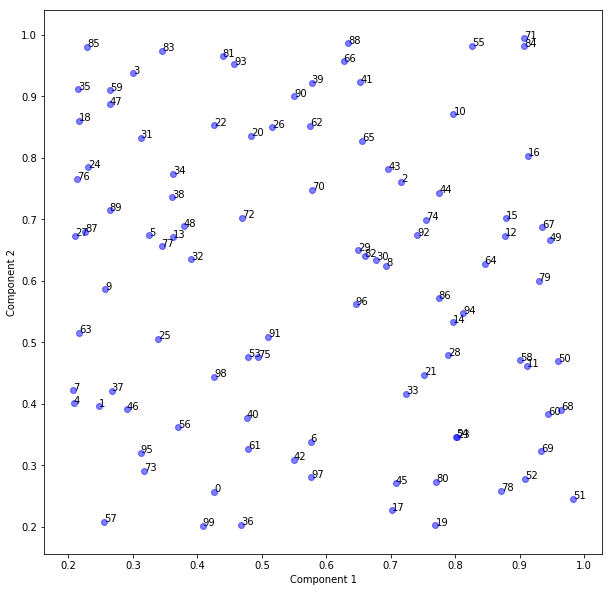

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 2 (0.2, 1)


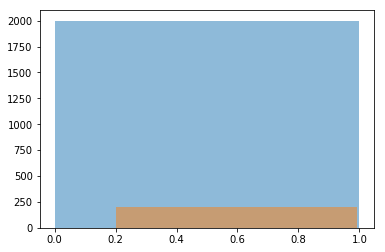

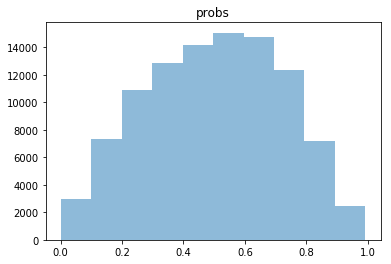

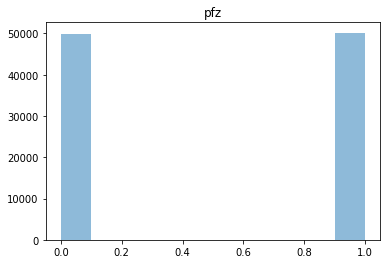

binary obs? True
<NN_utils.BigTable object at 0x7f45d886cbe0> <NN_utils.BigTable object at 0x7f45d982ac50> Tensor("psi_select_57:0", shape=(?, 1), dtype=int32) Tensor("q_select_57:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f45d92e0f60>
kk (100, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 2)
'rows' shape, (?, 2)
Blank init'd: <keras.initializers.RandomUniform object at 0x7f45d94b7550>
kk (1000, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 2)
'rows' shape, (?, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q_select (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
psi_select (InputLayer)     

Epoch 57/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7976 - acc: 0.5180
Epoch 58/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7964 - acc: 0.5185
Epoch 59/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7952 - acc: 0.5189
Epoch 60/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7940 - acc: 0.5192
Epoch 61/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7928 - acc: 0.5197
Epoch 62/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7916 - acc: 0.5200
Epoch 63/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7905 - acc: 0.5203
Epoch 64/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7894 - acc: 0.5206
Epoch 65/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7882 - acc: 0.5211
Epoch 66/100000
100000/100000 [===============

Epoch 134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7282 - acc: 0.5472
Epoch 135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7275 - acc: 0.5476
Epoch 136/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7268 - acc: 0.5481
Epoch 137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7262 - acc: 0.5485
Epoch 138/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7255 - acc: 0.5490
Epoch 139/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.7249 - acc: 0.5491
Epoch 140/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.7242 - acc: 0.5497
Epoch 141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7236 - acc: 0.5500
Epoch 142/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.7229 - acc: 0.5504
Epoch 143/100000
100000/100000 [=====

Epoch 211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6865 - acc: 0.5765
Epoch 212/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6860 - acc: 0.5767
Epoch 213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6856 - acc: 0.5772
Epoch 214/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6852 - acc: 0.5776
Epoch 215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6847 - acc: 0.5781
Epoch 216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6843 - acc: 0.5784
Epoch 217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6839 - acc: 0.5789
Epoch 218/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6835 - acc: 0.5791
Epoch 219/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6831 - acc: 0.5796
Epoch 220/100000
100000/100000 [=====

Epoch 288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6588 - acc: 0.6022
Epoch 289/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6585 - acc: 0.6025
Epoch 290/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6582 - acc: 0.6027
Epoch 291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6579 - acc: 0.6032
Epoch 292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6576 - acc: 0.6034
Epoch 293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6573 - acc: 0.6038
Epoch 294/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6570 - acc: 0.6042
Epoch 295/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6568 - acc: 0.6044
Epoch 296/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6565 - acc: 0.6047
Epoch 297/100000
100000/100000 [=====

Epoch 365/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6396 - acc: 0.6250
Epoch 366/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6394 - acc: 0.6251
Epoch 367/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6392 - acc: 0.6253
Epoch 368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6390 - acc: 0.6256
Epoch 369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6388 - acc: 0.6258
Epoch 370/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6386 - acc: 0.6262
Epoch 371/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6384 - acc: 0.6265
Epoch 372/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6382 - acc: 0.6266
Epoch 373/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6380 - acc: 0.6269
Epoch 374/100000
100000/100000 [=====

Epoch 442/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6260 - acc: 0.6431
Epoch 443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6259 - acc: 0.6432
Epoch 444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6257 - acc: 0.6434
Epoch 445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6256 - acc: 0.6435
Epoch 446/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6254 - acc: 0.6438
Epoch 447/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6253 - acc: 0.6441
Epoch 448/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6251 - acc: 0.6442
Epoch 449/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6250 - acc: 0.6444
Epoch 450/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6248 - acc: 0.6444
Epoch 451/100000
100000/100000 [=====

Epoch 519/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6162 - acc: 0.6555
Epoch 520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6160 - acc: 0.6555
Epoch 521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6159 - acc: 0.6557
Epoch 522/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6158 - acc: 0.6558
Epoch 523/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6157 - acc: 0.6559
Epoch 524/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6156 - acc: 0.6559
Epoch 525/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6155 - acc: 0.6561
Epoch 526/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6154 - acc: 0.6562
Epoch 527/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6153 - acc: 0.6564
Epoch 528/100000
100000/100000 [=====

Epoch 596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6090 - acc: 0.6644
Epoch 597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6089 - acc: 0.6644
Epoch 598/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6088 - acc: 0.6645
Epoch 599/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6087 - acc: 0.6647
Epoch 600/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6087 - acc: 0.6648
Epoch 601/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6086 - acc: 0.6649
Epoch 602/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6085 - acc: 0.6650
Epoch 603/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6084 - acc: 0.6651
Epoch 604/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6084 - acc: 0.6652
Epoch 605/100000
100000/100000 [=====

Epoch 673/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6037 - acc: 0.6702
Epoch 674/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6036 - acc: 0.6703
Epoch 675/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6035 - acc: 0.6703
Epoch 676/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6035 - acc: 0.6703
Epoch 677/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6034 - acc: 0.6704
Epoch 678/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6034 - acc: 0.6704
Epoch 679/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6033 - acc: 0.6705
Epoch 680/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6032 - acc: 0.6706
Epoch 681/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.6032 - acc: 0.6706
Epoch 682/100000
100000/100000 [=====

Epoch 750/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5996 - acc: 0.6748
Epoch 751/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5995 - acc: 0.6747
Epoch 752/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5995 - acc: 0.6747
Epoch 753/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5994 - acc: 0.6748
Epoch 754/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5994 - acc: 0.6748
Epoch 755/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5994 - acc: 0.6749
Epoch 756/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5993 - acc: 0.6749
Epoch 757/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5993 - acc: 0.6750
Epoch 758/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5992 - acc: 0.6751
Epoch 759/100000
100000/100000 [=====

Epoch 827/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5963 - acc: 0.6772
Epoch 828/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5963 - acc: 0.6773
Epoch 829/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5963 - acc: 0.6773
Epoch 830/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5962 - acc: 0.6775
Epoch 831/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5962 - acc: 0.6775
Epoch 832/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5961 - acc: 0.6776
Epoch 833/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5961 - acc: 0.6776
Epoch 834/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5961 - acc: 0.6776
Epoch 835/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5960 - acc: 0.6776
Epoch 836/100000
100000/100000 [=====

Epoch 904/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5936 - acc: 0.6794
Epoch 905/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5936 - acc: 0.6794
Epoch 906/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5935 - acc: 0.6793
Epoch 907/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5935 - acc: 0.6794
Epoch 908/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5935 - acc: 0.6793
Epoch 909/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5934 - acc: 0.6793
Epoch 910/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5934 - acc: 0.6793
Epoch 911/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5934 - acc: 0.6793
Epoch 912/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5933 - acc: 0.6793
Epoch 913/100000
100000/100000 [=====

Epoch 981/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5912 - acc: 0.6810
Epoch 982/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5911 - acc: 0.6810
Epoch 983/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5911 - acc: 0.6811
Epoch 984/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5911 - acc: 0.6810
Epoch 985/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5910 - acc: 0.6811
Epoch 986/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5910 - acc: 0.6811
Epoch 987/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5910 - acc: 0.6811
Epoch 988/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5909 - acc: 0.6811
Epoch 989/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5909 - acc: 0.6812
Epoch 990/100000
100000/100000 [=====

100000/100000 [==============================] - 0s 1us/step - loss: 0.5889 - acc: 0.6825
Epoch 1058/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5889 - acc: 0.6826
Epoch 1059/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5889 - acc: 0.6827
Epoch 1060/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5888 - acc: 0.6827
Epoch 1061/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5888 - acc: 0.6828
Epoch 1062/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5888 - acc: 0.6828
Epoch 1063/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5888 - acc: 0.6828
Epoch 1064/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6828
Epoch 1065/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5887 - acc: 0.6828
Epoch 1066/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6840
Epoch 1134/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6840
Epoch 1135/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6840
Epoch 1136/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5868 - acc: 0.6840
Epoch 1137/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6841
Epoch 1138/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6841
Epoch 1139/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6841
Epoch 1140/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6841
Epoch 1141/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5866 - acc: 0.6842
Epoch 1142/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6861
Epoch 1210/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5849 - acc: 0.6861
Epoch 1211/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6861
Epoch 1212/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6861
Epoch 1213/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6861
Epoch 1214/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5848 - acc: 0.6861
Epoch 1215/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5847 - acc: 0.6861
Epoch 1216/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5847 - acc: 0.6862
Epoch 1217/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5847 - acc: 0.6862
Epoch 1218/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5831 - acc: 0.6870
Epoch 1286/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5831 - acc: 0.6870
Epoch 1287/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5831 - acc: 0.6870
Epoch 1288/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6871
Epoch 1289/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6871
Epoch 1290/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6871
Epoch 1291/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5830 - acc: 0.6870
Epoch 1292/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5829 - acc: 0.6870
Epoch 1293/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5829 - acc: 0.6870
Epoch 1294/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6880
Epoch 1362/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6880
Epoch 1363/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6881
Epoch 1364/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6882
Epoch 1365/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5815 - acc: 0.6883
Epoch 1366/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5814 - acc: 0.6883
Epoch 1367/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5814 - acc: 0.6883
Epoch 1368/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5814 - acc: 0.6883
Epoch 1369/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5814 - acc: 0.6883
Epoch 1370/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5802 - acc: 0.6893
Epoch 1438/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5802 - acc: 0.6893
Epoch 1439/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5802 - acc: 0.6893
Epoch 1440/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6894
Epoch 1441/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6894
Epoch 1442/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6894
Epoch 1443/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6894
Epoch 1444/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6895
Epoch 1445/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5801 - acc: 0.6895
Epoch 1446/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5791 - acc: 0.6899
Epoch 1514/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5791 - acc: 0.6898
Epoch 1515/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5791 - acc: 0.6899
Epoch 1516/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5790 - acc: 0.6899
Epoch 1517/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5790 - acc: 0.6899
Epoch 1518/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5790 - acc: 0.6898
Epoch 1519/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5790 - acc: 0.6899
Epoch 1520/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5790 - acc: 0.6898
Epoch 1521/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5790 - acc: 0.6899
Epoch 1522/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6906
Epoch 1590/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1591/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1592/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1593/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1594/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1595/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1596/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1597/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5781 - acc: 0.6907
Epoch 1598/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 1666/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5774 - acc: 0.6911
Epoch 1667/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 1668/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 1669/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6910
Epoch 1670/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 1671/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 1672/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 1673/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5773 - acc: 0.6911
Epoch 1674/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1742/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1743/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1744/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1745/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1746/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1747/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1748/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5767 - acc: 0.6913
Epoch 1749/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5766 - acc: 0.6913
Epoch 1750/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6919
Epoch 1818/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6918
Epoch 1819/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5762 - acc: 0.6918
Epoch 1820/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6918
Epoch 1821/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6918
Epoch 1822/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6919
Epoch 1823/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6919
Epoch 1824/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6919
Epoch 1825/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5761 - acc: 0.6919
Epoch 1826/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6919
Epoch 1894/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6920
Epoch 1895/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6920
Epoch 1896/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6920
Epoch 1897/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6920
Epoch 1898/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6921
Epoch 1899/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6921
Epoch 1900/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6921
Epoch 1901/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5757 - acc: 0.6921
Epoch 1902/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1970/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1971/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1972/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1973/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1974/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1975/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6922
Epoch 1976/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6921
Epoch 1977/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5753 - acc: 0.6922
Epoch 1978/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2046/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2047/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2048/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2049/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2050/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2051/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2052/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2053/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5750 - acc: 0.6926
Epoch 2054/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2122/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2123/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2124/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2125/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2126/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2127/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2128/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6929
Epoch 2129/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5747 - acc: 0.6930
Epoch 2130/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2198/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2199/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2200/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2201/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2202/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2203/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6927
Epoch 2204/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6927
Epoch 2205/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5745 - acc: 0.6928
Epoch 2206/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6929
Epoch 2274/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6929
Epoch 2275/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6929
Epoch 2276/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6928
Epoch 2277/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6928
Epoch 2278/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6928
Epoch 2279/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6928
Epoch 2280/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6929
Epoch 2281/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5744 - acc: 0.6929
Epoch 2282/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6929
Epoch 2350/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6929
Epoch 2351/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2352/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2353/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2354/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2355/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2356/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2357/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5742 - acc: 0.6928
Epoch 2358/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2426/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2427/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2428/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2429/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2430/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2431/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2432/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6930
Epoch 2433/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6931
Epoch 2434/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6932
Epoch 2502/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6932
Epoch 2503/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6932
Epoch 2504/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6933
Epoch 2505/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6933
Epoch 2506/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6933
Epoch 2507/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6933
Epoch 2508/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6933
Epoch 2509/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5741 - acc: 0.6933
Epoch 2510/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2578/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2579/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2580/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2581/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2582/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2583/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2584/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6935
Epoch 2585/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6934
Epoch 2586/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6931
Epoch 2654/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6931
Epoch 2655/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6931
Epoch 2656/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6932
Epoch 2657/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6932
Epoch 2658/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6932
Epoch 2659/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6932
Epoch 2660/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6932
Epoch 2661/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5740 - acc: 0.6932
Epoch 2662/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2730/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2731/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2732/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2733/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2734/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2735/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2736/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2737/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2738/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2806/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2807/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2808/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2809/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2810/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2811/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2812/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2813/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6934
Epoch 2814/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2882/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2883/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2884/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2885/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2886/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2887/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2888/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2889/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2890/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2958/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2959/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2960/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2961/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2962/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6933
Epoch 2963/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2964/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2965/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5739 - acc: 0.6932
Epoch 2966/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3034/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3035/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3036/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3037/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3038/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3039/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3040/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3041/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3042/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3110/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3111/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3112/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5738 - acc: 0.6931
Epoch 3113/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5738 - acc: 0.6931
Epoch 3114/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3115/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3116/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3117/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3118/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3186/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3187/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3188/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3189/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3190/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3191/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3192/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3193/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3194/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3262/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3263/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3264/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3265/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3266/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3267/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3268/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3269/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3270/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3338/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3339/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3340/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6932
Epoch 3341/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3342/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3343/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3344/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3345/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6931
Epoch 3346/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3414/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3415/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3416/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3417/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3418/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3419/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3420/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3421/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3422/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3490/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3491/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3492/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3493/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3494/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3495/100000
100000/100000 [==============================] - 0s 0us/step - loss: 0.5738 - acc: 0.6933
Epoch 3496/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3497/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3498/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3566/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3567/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3568/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3569/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3570/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3571/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3572/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3573/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3574/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3642/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3643/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3644/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3645/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3646/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3647/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3648/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3649/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3650/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3718/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3719/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3720/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3721/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3722/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3723/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3724/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3725/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3726/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3794/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3795/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3796/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3797/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3798/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3799/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3800/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3801/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 3802/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3870/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3871/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3872/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3873/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3874/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3875/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3876/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3877/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3878/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3946/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3947/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3948/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3949/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3950/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3951/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3952/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3953/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 3954/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4022/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4023/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4024/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4025/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4026/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4027/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4028/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4029/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4030/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4098/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4099/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4100/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4101/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4102/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4103/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4104/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4105/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4106/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4174/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4175/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4176/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4177/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4178/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4179/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4180/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4181/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4182/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4250/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4251/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4252/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4253/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4254/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4255/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4256/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4257/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4258/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4326/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4327/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4328/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4329/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4330/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4331/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4332/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4333/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4334/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4402/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4403/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4404/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4405/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4406/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4407/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4408/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4409/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4410/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4478/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4479/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4480/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4481/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4482/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4483/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4484/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4485/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4486/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4554/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4555/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4556/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4557/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4558/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4559/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4560/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4561/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4562/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4630/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4631/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4632/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4633/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4634/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4635/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4636/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4637/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6933
Epoch 4638/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4706/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4707/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4708/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4709/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4710/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4711/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4712/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4713/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4714/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4782/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4783/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4784/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4785/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4786/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4787/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4788/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4789/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4790/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4858/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4859/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4860/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4861/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4862/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4863/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4864/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4865/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6934
Epoch 4866/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4934/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4935/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4936/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4937/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4938/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4939/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4940/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4941/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 4942/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5010/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5011/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5012/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5013/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5014/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5015/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5016/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5017/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5018/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5086/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5087/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5088/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5089/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5090/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5091/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5092/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5093/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5094/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5162/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5163/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5164/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5165/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5166/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5167/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5168/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5169/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5170/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5238/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5239/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5240/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5241/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5242/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5243/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5244/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5245/100000
100000/100000 [==============================] - 0s 1us/step - loss: 0.5738 - acc: 0.6935
Epoch 5246/100000
100000/100000 [=============

In [55]:
import copy

qws_list = []
sws_list = []
tr_list = []
# questions=None
stu_list=[]
n_runs = 3
tw=None
qn_av = None
qn_std = None

a0s = numpy.linspace(-2,2,n_runs)

pred_list = []
n_students= 1000

# n_factors, min_active, max_active = 5,5,5
# a0=(0,.5)
# emb_w = 5

n_factors, min_active, max_active = 2,2,2
a0=(0.2,1)
emb_w = 2

# n_factors, min_active, max_active = 10,10,10
# a0 = (0, 0.26)
# emb_w = 10

model_list=[]
rasch=False

questions=None
for a, emb_w in enumerate([emb_w] * n_runs): #range(n_runs):
#     a1,a0,av_c,offset,test_w = generate_params(min_active, max_active)
    if tw is None:
        tw=test_w
    
    if rasch:
        _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
    else:
        _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
    
    if questions is None:
        students2 = students_temp    

        questions = qz_temp
        qn_av = numpy.mean(questions, axis=0)
        qn_std = numpy.std(questions, axis=0)
    plot_items([], questions, None)
    
    stu_list.append(students2)  

    
    print("~ ~ ~ ~~ ATTEMPT",a, a0)
    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
    plt.show()

#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
#     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))

    sz=[]
    qz=[]
    pfz=[]
    probs=numpy.zeros((len(students2), len(questions)))
            
    for vi in range(len(students2)):
        for mi in range(len(questions)):
            for _ in range(1):

                if rasch:
        #                 zmask = (qws[mi]==-10).astype(int)
                    deltas = students2[vi]-questions[mi]
                    prs = logistic(deltas,1,0)
        #                 prs = numpy.maximum(zmask,prs)
                else:
                    p = students2[vi]
                    q = questions[mi]
#                     print("p",p)
#                     print("q",q)
                    prs = (1-q)+(p*q)
        
                pr = numpy.prod(prs)
#                 print(pr)
                sz.append(vi)
                qz.append(mi)
#                 ob = (random.random() < pr)
                probs[vi,mi] = pr
#                 pfz.append(ob)
    
    all_pairs = list(zip(sz,qz))
#     all_pairs = numpy.random.permutation(all_pairs)
    all_pairs = numpy.array(all_pairs)
#     v_pairs = all_pairs[0:100]
    tr_pairs = all_pairs#[100:]
    pfz = [(random.random() < probs[vi,mi]) for (vi,mi) in tr_pairs]
    pfz = numpy.array(pfz).flatten()
    sz = tr_pairs[:,0]
    qz = tr_pairs[:,1]

    
    #     print(v_pairs)
#     vpfz = [(random.random() < probs[vi,mi]) for (vi,mi) in v_pairs]
#     vpfz = [probs[vi,mi] for (vi,mi) in v_pairs]
#     vpfz = numpy.array(vpfz).flatten()
#     print(vpfz)
#     vsz = v_pairs[:,0]
#     vqz = v_pairs[:,1]
#     print(vsz,vqz)
    vqz,vsz,vpfz = None,None,None
    
    plt.hist(probs.flatten(), alpha=0.5)
    plt.title("probs")
    plt.show()
    
    plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
    plt.title("pfz")
    plt.show()

#     break
    
# for runix in range(n_runs):
#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
    obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
    print("binary obs?", obs_are_binary)

    s_table2, qn_table2, m2, h2 = generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=emb_w)
    qws2= copy.copy(qn_table2.get_weights()[0])
    sws2= copy.copy(s_table2.get_weights()[0])
    
    pred_probs = m2.predict([qz, sz])
    pred_list.append(pred_probs)
    model_list.append(m2)
    
#     qg = q_gates.get_weights()[0]
#     qg_list.append(qg)
#     if qn_av is None:
#         qn_av = numpy.mean(qws2)

    sws_list.append(sws2)
    qws_list.append(qws2)

There are 3 els in sws_list and 3 els in qws_list


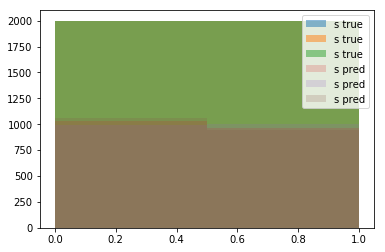

2
len qws_list 3
med 0.574442 for shape (100, 2)
med 0.589731 for shape (100, 2)
med 0.542916 for shape (100, 2)


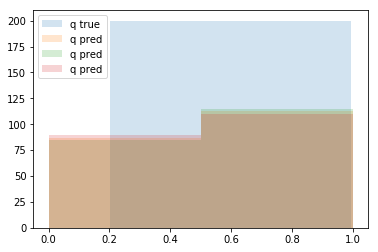

In [56]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in stu_list:
    plt.hist(ss.flatten(), alpha=0.5, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()


plt.hist(questions.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))
print(bin_spread(qws2))
# plt.show()

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

3


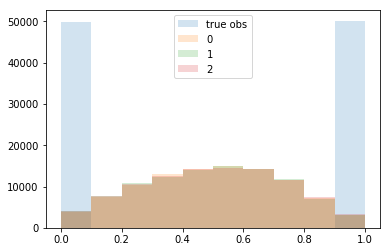

In [57]:
print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.2, label=str(ix))
plt.legend()
plt.show()

2 comps, so no dim reduc
pred list shape (3, 100, 2)
real items shape (100, 2)
0 (100, 2) (100, 2) 10
[[  4.409e-01   1.831e-01]
 [  3.027e-01   3.572e-01]
 [  5.938e-01   8.160e-01]
 [  2.708e-01   9.340e-01]
 [  1.670e-01   4.015e-01]
 [  2.718e-01   6.847e-01]
 [  6.152e-01   2.748e-01]
 [  4.227e-02   5.434e-01]
 [  7.365e-01   5.305e-01]
 [  1.910e-01   5.750e-01]
 [  8.023e-01   8.341e-01]
 [  9.120e-01   3.591e-01]
 [  1.000e+00   4.073e-01]
 [  3.725e-01   6.489e-01]
 [  8.413e-01   4.619e-01]
 [  9.805e-01   5.276e-01]
 [  9.701e-01   7.321e-01]
 [  7.059e-01   1.907e-01]
 [  0.000e+00   9.584e-01]
 [  8.347e-01   0.000e+00]
 [  4.277e-01   8.240e-01]
 [  8.287e-01   3.403e-01]
 [  3.982e-01   8.189e-01]
 [  8.561e-01   2.503e-01]
 [  1.513e-01   8.225e-01]
 [  2.836e-01   5.437e-01]
 [  4.446e-01   8.359e-01]
 [  2.072e-01   6.048e-01]
 [  8.605e-01   3.042e-01]
 [  6.023e-01   6.682e-01]
 [  6.973e-01   6.167e-01]
 [  1.608e-01   8.870e-01]
 [  2.765e-01   7.461e-01]
 [  6.3

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


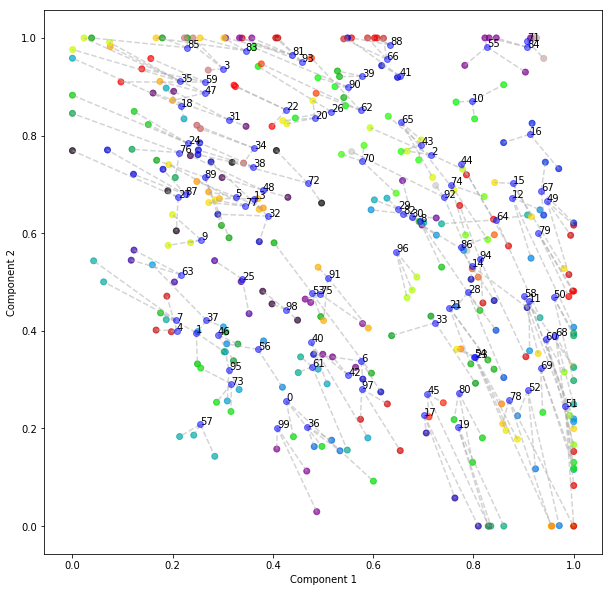

len Cs 3
Rand: 0.423168483635
Rand: 0.47167033689
Rand: 0.423168483635
Rand: 0.448267843656
Rand: 0.47167033689
Rand: 0.448267843656
Mean rand score = 0.447702221394 0.0198048376026


In [58]:
plot_items(qws_list, questions, 0)

In [202]:
for qw in qws_list:#, sw_av_list):
    print(qw)

[[ 0.614]
 [ 0.683]
 [ 0.793]
 [ 0.814]
 [ 0.515]
 [ 0.796]
 [ 0.888]
 [ 0.955]
 [ 0.496]
 [ 0.677]
 [ 0.993]
 [ 0.831]
 [ 0.859]
 [ 0.757]
 [ 0.849]
 [ 1.   ]
 [ 0.976]
 [ 0.763]
 [ 0.651]
 [ 0.915]
 [ 0.779]
 [ 0.806]
 [ 0.779]
 [ 0.932]
 [ 0.882]
 [ 0.928]
 [ 0.638]
 [ 0.907]
 [ 0.652]
 [ 0.774]
 [ 0.872]
 [ 0.745]
 [ 0.767]
 [ 0.597]
 [ 0.455]
 [ 0.749]
 [ 0.774]
 [ 0.778]
 [ 0.898]
 [ 0.743]
 [ 0.884]
 [ 0.798]
 [ 0.757]
 [ 0.68 ]
 [ 0.632]
 [ 0.853]
 [ 0.352]
 [ 0.932]
 [ 0.908]
 [ 0.249]
 [ 0.68 ]
 [ 0.757]
 [ 0.918]
 [ 0.846]
 [ 0.971]
 [ 0.803]
 [ 0.652]
 [ 0.776]
 [ 0.693]
 [ 0.776]
 [ 0.591]
 [ 0.872]
 [ 0.99 ]
 [ 0.791]
 [ 0.784]
 [ 0.91 ]
 [ 0.895]
 [ 0.821]
 [ 0.755]
 [ 0.602]
 [ 0.943]
 [ 1.   ]
 [ 0.936]
 [ 0.976]
 [ 0.878]
 [ 0.919]
 [ 0.882]
 [ 0.895]
 [ 0.61 ]
 [ 0.86 ]
 [ 0.819]
 [ 0.645]
 [ 0.905]
 [ 0.921]
 [ 0.819]
 [ 0.924]
 [ 0.763]
 [ 0.805]
 [ 0.509]
 [ 0.728]
 [ 0.642]
 [ 0.9  ]
 [ 0.726]
 [ 0.751]
 [ 0.488]
 [ 1.   ]
 [ 0.897]
 [ 0.956]
 [ 0.876]
 [ 0.872]]

In [59]:
tot_sqerr = 0
mean_err_list = []
mean_hit_list = []
for sw,qw,m,stz in zip(sws_list, qws_list, model_list, stu_list):
    err_list = []
    hit_list = []
    for (six,srow), (qix,qrow) in zip(enumerate(sw),enumerate(qw)):
        tq = questions[qix,:]
        ts = stz[six,:]
#         print("raw",tq,ts)
#         print("dif",ts-tq)
#         print(numpy.prod(logistic(ts-tq,1,0)))
        if rasch:
            true_p = numpy.prod(logistic(ts-tq,1,0))
        else:
            true_p = numpy.prod((1-tq)+(ts*tq))
        pred_p = m.predict([[qix],[six]])
        err_list.append(numpy.power(true_p - pred_p, 2))
        hit_list.append(int(numpy.round(true_p)==numpy.round(pred_p)))
#         sqerr = numpy.power(true_p - pred_p, 2)
        print(srow, qrow, "//", pred_p, true_p )
#         print("//", pred_p, true_p )

    numpy.set_printoptions(precision=3)
    print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    mean_err_list.append(numpy.sqrt(numpy.mean(err_list)))
    mean_hit_list.append(numpy.sqrt(numpy.mean(hit_list)))
    
print(mean_err_list)
print(mean_hit_list)

[ 1.     0.381] [ 0.441  0.183] // [[ 0.887]] 0.843771795103
[ 0.126  0.   ] [ 0.303  0.357] // [[ 0.473]] 0.47093005834
[ 0.623  0.305] [ 0.594  0.816] // [[ 0.336]] 0.323871311861
[ 0.198  0.439] [ 0.271  0.934] // [[ 0.372]] 0.370666110257
[ 0.55   0.263] [ 0.167  0.402] // [[ 0.651]] 0.656064651285
[ 0.497  0.718] [ 0.272  0.685] // [[ 0.697]] 0.696631103238
[ 0.129  0.694] [ 0.615  0.275] // [[ 0.425]] 0.43292931093
[ 0.985  0.961] [ 0.042  0.543] // [[ 0.978]] 0.987892665376
[ 0.362  0.157] [ 0.737  0.53 ] // [[ 0.293]] 0.292969813505
[ 0.808  0.   ] [ 0.191  0.575] // [[ 0.409]] 0.426525623333
[ 0.931  0.591] [ 0.802  0.834] // [[ 0.622]] 0.583699046623
[ 0.657  0.688] [ 0.912  0.359] // [[ 0.61]] 0.656080301759
[ 0.875  0.367] [ 1.     0.407] // [[ 0.65]] 0.527407616786
[ 0.263  0.7  ] [ 0.373  0.649] // [[ 0.584]] 0.698781871921
[ 0.134  0.486] [ 0.841  0.462] // [[ 0.207]] 0.20758406135
[ 0.452  0.741] [ 0.981  0.528] // [[ 0.4]] 0.347792982815
[ 0.445  0.681] [ 0.97   0.732]

[ 0.367  0.734] [ 0.     0.829] // [[ 0.779]] 0.689670149871
[ 0.292  0.706] [ 0.83  0.42] // [[ 0.361]] 0.351039951705
[ 0.568  0.732] [ 0.332  0.795] // [[ 0.674]] 0.706435552453
[ 0.769  0.31 ] [ 0.9    0.325] // [[ 0.615]] 0.587136870685
[ 0.857  0.707] [  1.027e-04   9.564e-01] // [[ 0.719]] 0.588226510917
[ 0.144  0.718] [ 0.883  0.   ] // [[ 0.244]] 0.30385342967
[ 0.114  0.215] [ 0.501  0.337] // [[ 0.409]] 0.444115675608
[ 0.802  0.806] [ 0.942  0.37 ] // [[ 0.755]] 0.721611177203
[ 0.293  0.266] [ 0.687  0.19 ] // [[ 0.443]] 0.390748547368
[ 0.56   0.597] [ 0.401  0.845] // [[ 0.543]] 0.462013257397
[ 0.427  0.396] [ 0.622  0.701] // [[ 0.372]] 0.401269240189
[ 0.416  0.788] [ 0.708  0.659] // [[ 0.505]] 0.571147777579
[ 0.192  0.326] [ 0.819  0.346] // [[ 0.259]] 0.22263217718
[ 0.563  0.866] [ 0.639  0.29 ] // [[ 0.693]] 0.68098986087
[ 0.401  0.46 ] [ 0.293  0.804] // [[ 0.466]] 0.53493710123
[ 0.306  0.263] [ 0.814  0.255] // [[ 0.353]] 0.38912153893
[ 0.648  1.   ] [ 0.9

0 (100, 2) (100, 2) 10
err 0.0612168
0 (100, 2) (100, 2) 10
err 0.0539285
ensem err 0.048991
2 comps, so no dim reduc
pred list shape (1, 100, 2)
real items shape (100, 2)
0 (100, 2) (100, 2) 10
[[ 0.549  0.128]
 [ 0.213  0.384]
 [ 0.723  0.75 ]
 [ 0.232  1.   ]
 [ 0.193  0.435]
 [ 0.314  0.679]
 [ 0.53   0.326]
 [ 0.125  0.462]
 [ 0.752  0.533]
 [ 0.218  0.609]
 [ 0.813  0.886]
 [ 1.     0.217]
 [ 0.924  0.598]
 [ 0.332  0.671]
 [ 0.851  0.477]
 [ 0.879  0.669]
 [ 0.889  0.805]
 [ 0.786  0.029]
 [ 0.205  0.866]
 [ 0.845  0.   ]
 [ 0.45   0.851]
 [ 0.818  0.327]
 [ 0.324  0.902]
 [ 0.866  0.181]
 [ 0.062  0.866]
 [ 0.344  0.468]
 [ 0.458  0.901]
 [ 0.095  0.728]
 [ 0.806  0.425]
 [ 0.664  0.647]
 [ 0.692  0.669]
 [ 0.274  0.855]
 [ 0.331  0.611]
 [ 0.76   0.361]
 [ 0.298  0.779]
 [ 0.049  0.995]
 [ 0.525  0.165]
 [ 0.276  0.403]
 [ 0.253  0.778]
 [ 0.531  0.926]
 [ 0.54   0.251]
 [ 0.599  0.96 ]
 [ 0.532  0.339]
 [ 0.643  0.803]
 [ 0.813  0.674]
 [ 0.726  0.238]
 [ 0.314  0.368]
 [ 0.1

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


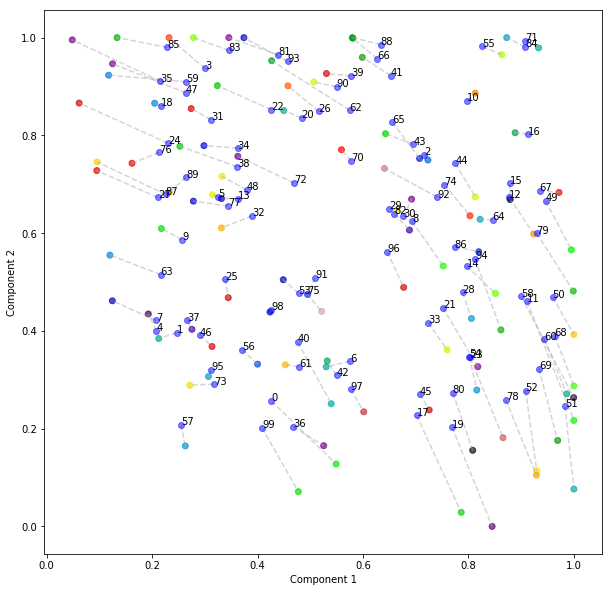

len Cs 1
Mean rand score = nan nan


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.median(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.median(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([mean_en,], questions, None)
# plot_items([], mean_en, 0)


In [20]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

NameError: name 'm_list' is not defined

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [46]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [47]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()